In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

In [2]:
# Load data 
df = pd.read_csv(r"D:\JOB\1 Pricing analyst\1 Price elasticity & demand forecasting\2 Time series\time_series_dataset.csv")

In [3]:
df.head()

,date,price,demand,competitor_price,economic_index,promotion,day_of_week,month,year,quarter,week_of_year,demand_moving_avg,price_change,demand_lag_1
0,2015-01-01,20.248357,391.973267,18.448952,0.725858,0,3,1,2015,1,1,391.973267,0.000000,400.140680
1,2015-01-02,19.977995,397.369221,21.918927,1.215202,0,4,1,2015,1,1,394.671244,-0.013352,391.973267
2,2015-01-03,20.418086,392.564124,21.643247,0.971469,0,5,1,2015,1,1,393.968871,0.022029,397.369221
3,2015-01-04,20.902848,397.532455,22.444680,0.981343,0,6,1,2015,1,1,394.859767,0.023742,392.564124
4,2015-01-05,20.071314,412.871847,20.851262,0.994398,0,0,1,2015,1,2,398.462183,-0.039781,397.532455


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3653 entries, 0 to 3652
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               3653 non-null   object 
 1   price              3653 non-null   float64
 2   demand             3653 non-null   float64
 3   competitor_price   3653 non-null   float64
 4   economic_index     3653 non-null   float64
 5   promotion          3653 non-null   int64  
 6   day_of_week        3653 non-null   int64  
 7   month              3653 non-null   int64  
 8   year               3653 non-null   int64  
 9   quarter            3653 non-null   int64  
 10  week_of_year       3653 non-null   int64  
 11  demand_moving_avg  3653 non-null   float64
 12  price_change       3653 non-null   float64
 13  demand_lag_1       3653 non-null   float64
dtypes: float64(7), int64(6), object(1)
memory usage: 399.7+ KB


# Preprocess data 

In [5]:
df["date"] = pd.to_datetime(df["date"], format="%Y-%m-%d")

In [6]:
# sort by date 
df = df.sort_values("date")

In [7]:
# Set date as index
df.set_index("date",inplace =True)

In [8]:
df = df.asfreq("D")  # Add this line

In [9]:
# Check for missing values
df.isnull().sum()

price                0
demand               0
competitor_price     0
economic_index       0
promotion            0
day_of_week          0
month                0
year                 0
quarter              0
week_of_year         0
demand_moving_avg    0
price_change         0
demand_lag_1         0
dtype: int64

<Axes: xlabel='date'>

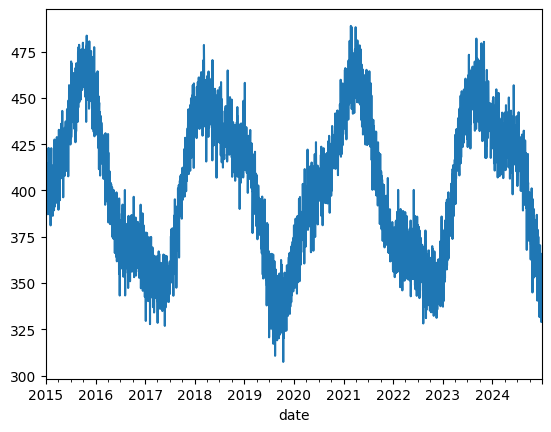

In [10]:
# Visualize demand 
df["demand"].plot()

# Check for Stationarity (ADF Test)

In [11]:
# ADF test 
adfuller(df["demand"])

(-1.2479315163100657,
 0.65264466339541,
 30,
 3622,
 {'1%': -3.4321567201852456,
  '5%': -2.862338308122449,
  '10%': -2.5671949518327932},
 27556.353133444478)

In [12]:
result = adfuller(df["demand"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] <= 0.05:
    print("✅ Series is stationary")
else:
    print("❌ Series is NOT stationary")

ADF Statistic: -1.2479315163100657
p-value: 0.65264466339541
❌ Series is NOT stationary


In [13]:
# Differencing if not stationary
df["demand_diff"] = df["demand"].diff()
df = df.dropna()

In [14]:
# ADF test again on differenced series
result = adfuller(df["demand_diff"])
print(f"\nAfter differencing — ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] <= 0.05:
    print("✅ Differenced series is stationary")
else:
    print("❌ Still not stationary")


After differencing — ADF Statistic: -9.790367116787861
p-value: 6.377437557058025e-17
✅ Differenced series is stationary


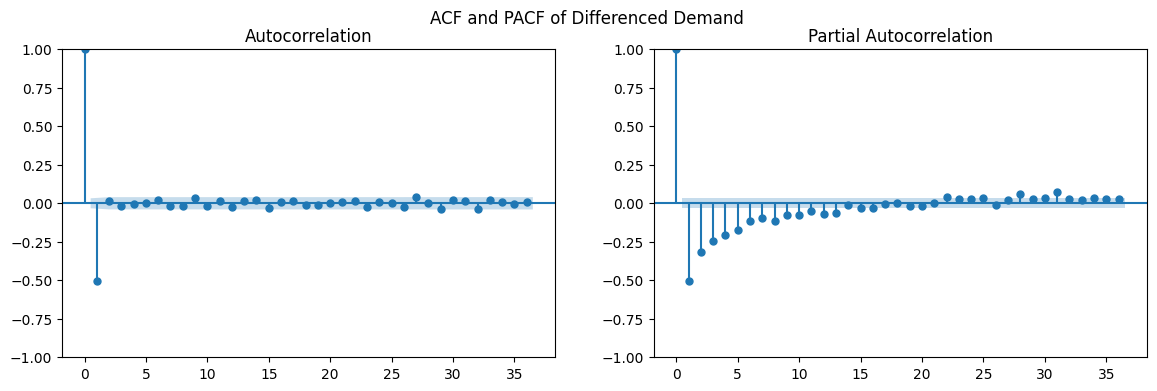

In [16]:
# ACF and PACF plots to determine p and q
fig, ax = plt.subplots(1, 2, figsize=(14,4))
plot_acf(df["demand_diff"], ax=ax[0])
plot_pacf(df["demand_diff"], ax=ax[1])
plt.suptitle("ACF and PACF of Differenced Demand")
plt.show()

In [15]:
# Train-test split
train = df["demand"][:-180]
test = df["demand"][-180:]

In [17]:
# Based on ACF/PACF plot, set values — for example (you'll decide visually):
p = 14  # from PACF
d = 1  # differenced once
q = 2  # from ACF

In [18]:
# Fit ARIMA model (example order)
model = ARIMA(train, order=(p,d,q))
model_fit = model.fit()

C:\Users\Kush baba the great\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
# Forecast
forecast = model_fit.forecast(steps=180)
forecast.index = test.index

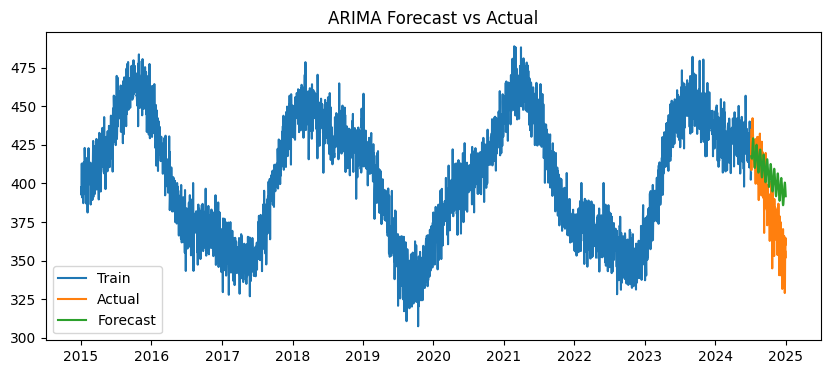

In [20]:
# Plot forecast vs actual
plt.figure(figsize=(10,4))
plt.plot(train.index, train, label="Train")
plt.plot(test.index, test, label="Actual")
plt.plot(forecast.index, forecast, label="Forecast")
plt.title("ARIMA Forecast vs Actual")
plt.legend()
plt.show()

In [21]:
# RMSE
rmse = sqrt(mean_squared_error(test, forecast))
print(f"\nRMSE: {rmse:.2f}")


RMSE: 27.60
